In [114]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [120]:
import numpy as np
import nibabel as nib
import pandas as pd
import os
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt

In [122]:
def show_MRI(file_path, Name):
    img = nib.load(file_path)
    
    # Get the image data as a NumPy array
    image = img.get_fdata()
    print("MRI Data Shape:", image.shape[0], image.shape[1], image.shape[2])
    
    plt.figure(figsize=(10, 10))
    #image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[image.shape[0] // 2 ,:,:]),cmap = 'gray')
    # plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title(f'Class0: {Name}')
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,image.shape[1] // 2 ,:]),cmap = 'gray')
    plt.title(f'Class: {Name}')
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,image.shape[2] // 2 ]),cmap = 'gray')
    plt.title(f'Class: {Name}')

MRI Data Shape: 193 229 193
MRI Data Shape: 181 217 181


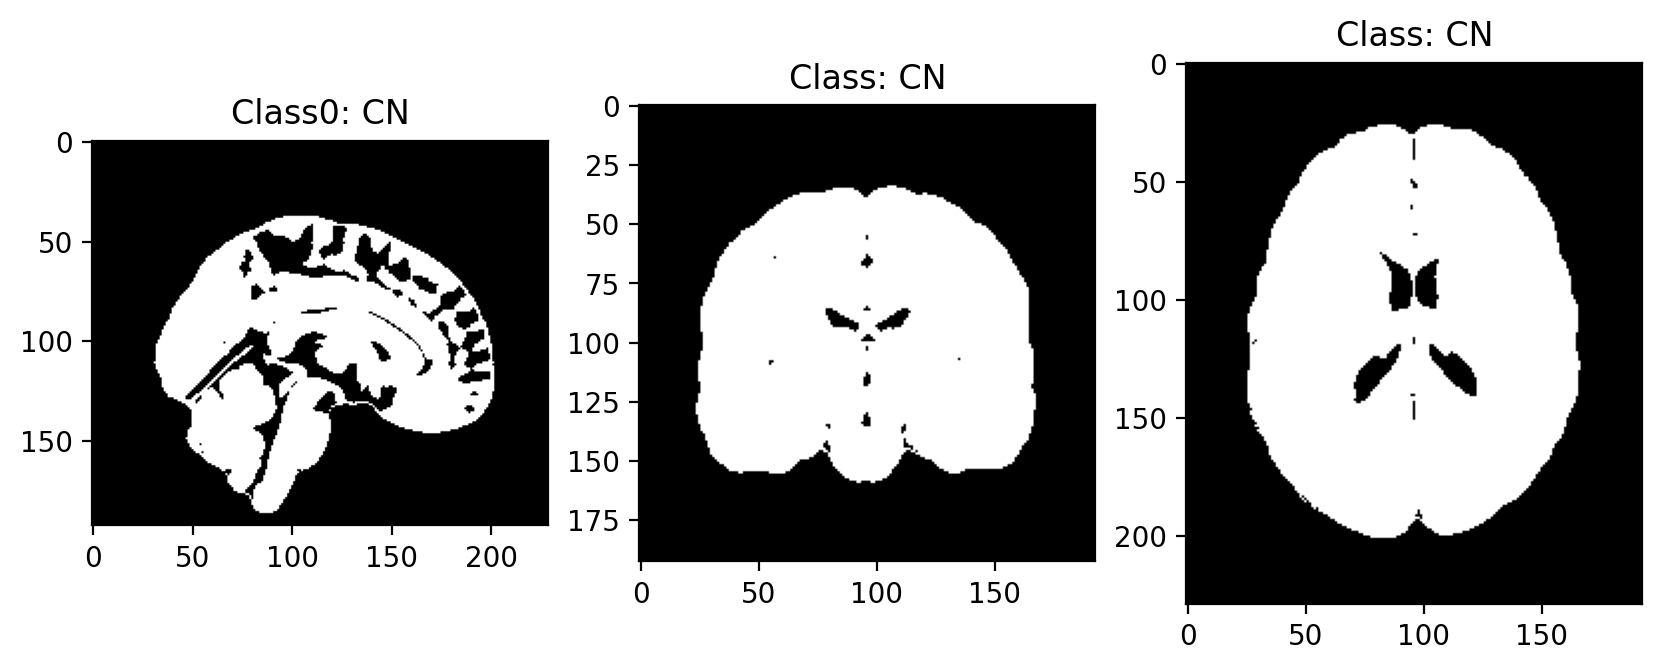

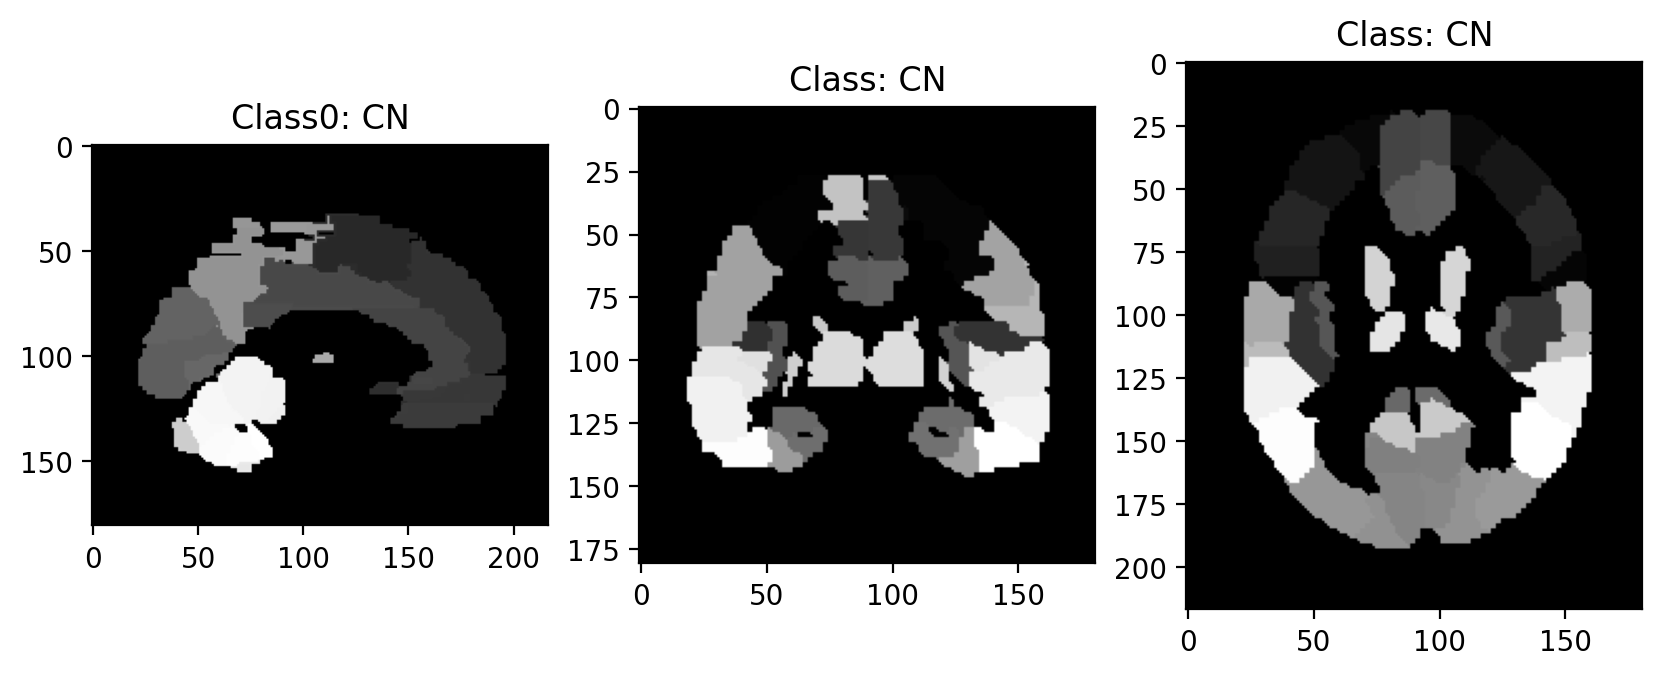

In [124]:
region_file_path = "data/binary_brain_mask.nii.gz" #CN
show_MRI(region_file_path, 'CN')
region_file_path = "data/aal.nii.gz" #CN
show_MRI(region_file_path, 'CN')

In [57]:
region_file_path = "./Processed_CN_AD_Mined_ADNI_FILE_Data/I185313/brainmask.mgz" #CN
show_MRI(region_file_path, 'CN')
region_file_path = "./output_path/I185313/processed_brainmask.mgz" #CN
show_MRI(region_file_path, 'CN')
region_file_path = "./output_path/I185313/processed_brainmask2.mgz" #CN
show_MRI(region_file_path, 'CN')

FileNotFoundError: No such file or no access: 'Processed_CN_AD_Mined_ADNI_FILE_Data/I185313/brainmask.mgz'

In [126]:
csv_path = "./Adni CSV/ADNI_CN_AD.csv"
base_image_folder_path = "./Resized_Processed_CN_AD_File_Data"
mri_images = os.listdir(base_image_folder_path)
    
csv_data = pd.read_csv(csv_path)
df = pd.DataFrame(csv_data)
df.shape

(5728, 12)

In [128]:
# def load_metadata(df):
#     """
#     Load metadata from CSV, filter by description, and encode group labels as integers.
#     """
#     # Filter the dataframe to include only the required descriptions
#     valid_descriptions = [
#         "FreeSurfer Cross-Sectional Processing brainmask",
#     ]
#     df = df[df['Description'].isin(valid_descriptions)].copy()

#     CN_OR_AD = [
#         "CN",
#         "AD"
#     ]
#     df = df[df['Group'].isin(CN_OR_AD)].copy()
    
#     image_ids = df['Image Data ID'].values
#     df['Group'] = df['Group'].astype(str)
    
#     # Encode groups as integers
#     group_labels, unique_groups = pd.factorize(df['Group'])
#     print(f"Class Mapping: {dict(enumerate(unique_groups))}")
#     file_paths = [os.path.join(base_image_folder_path, img_id, "brainmask.mgz") for img_id in image_ids]
    
#     # Convert to NumPy array
#     file_paths_array = np.array(file_paths)
#     group_labels = np.array(group_labels)
    
    
#     ages = df['Age'].values
#     return df, image_ids, file_paths_array, group_labels


def load_metadata(df):
    """
    Load metadata from CSV, filter by description, and encode group labels as integers.
    Selects 500 AD and 600 CN samples.
    """
    # Filter the dataframe to include only the required descriptions
    valid_descriptions = [
        "FreeSurfer Cross-Sectional Processing brainmask",
    ]
    df = df[df['Description'].isin(valid_descriptions)].copy()

    # Keep only CN and AD groups
    df = df[df['Group'].isin(["CN", "AD"])].copy()

    # Shuffle dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Select 500 AD and 600 CN
    df_ad = df[df['Group'] == "AD"].sample(n=600, random_state=42)
    df_cn = df[df['Group'] == "CN"].sample(n=700, random_state=42)

    # Combine selected samples
    df_selected = pd.concat([df_cn, df_ad]).reset_index(drop=True)

    # Get Image IDs
    image_ids = df_selected['Image Data ID'].values

    # Encode groups as integers
    group_labels, unique_groups = pd.factorize(df_selected['Group'])
    print(f"Class Mapping: {dict(enumerate(unique_groups))}")

    # Construct file paths
    file_paths = [os.path.join(base_image_folder_path, img_id, "brainmask.mgz") for img_id in image_ids]

    # Convert to NumPy arrays
    file_paths_array = np.array(file_paths)
    group_labels = np.array(group_labels)
    ages = df_selected['Age'].values

    return df_selected, image_ids, file_paths_array, group_labels

def load_and_resize_nii(file_path, target_shape=(256, 256, 256), normalize=True):
    """
    Load a NIfTI image, resize it, and normalize the data.
    """
    nii_img = nib.load(file_path)
    img_data = nii_img.get_fdata(dtype=np.float32)

    if normalize:
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data) + 1e-8)
    
    img_resized = resize(img_data, target_shape, mode='constant', anti_aliasing=True)
    return img_resized

In [130]:
csv_df, image_ids, file_paths, group_labels = load_metadata(df)
# print(file_paths)
# print(group_labels)

Class Mapping: {0: 'CN', 1: 'AD'}


In [132]:
shapes = set()
size_0 = []
size_1 = []
size_2 = []

for img_id in image_ids:

    # Construct the file path for the image based on the given directory structure
    file_path = os.path.join(base_image_folder_path, img_id, "brainmask.mgz")
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the image data
        img = nib.load(file_path)
        data = img.get_fdata()
    
        # Find non-zero (non-black) regions
        nonzero_coords = np.argwhere(data > 0)
        min_coords = nonzero_coords.min(axis=0)
        max_coords = nonzero_coords.max(axis=0) + 1
    
        # Crop the data
        cropped_data = data[min_coords[0]:max_coords[0], 
                            min_coords[1]:max_coords[1], 
                            min_coords[2]:max_coords[2]]
    
        # Compute resize scale
        # current_shape = cropped_data.shape
        shapes.add(cropped_data.shape)
        size_0.append(cropped_data.shape[0])
        size_1.append(cropped_data.shape[1])
        size_2.append(cropped_data.shape[2])
        # Use 'groups' as the target label for classification

# print("Check if the shapes are homogeneous", shapes)


KeyboardInterrupt: 

In [18]:
print(max(size_0), max(size_1), max(size_2))
print(len(shapes))

NameError: name 'size_0' is not defined

In [106]:
def process_mri_images(image_ids, base_image_folder_path, output_path, target_shape):
    """
    Process 3D MRI images by:
    1. Cropping to only include non-zero values
    2. Padding to reach a target size
    3. Saving to output directory with folders based on image_id
    
    Args:
        image_ids (list): List of image IDs to process
        base_image_folder_path (str): Base path containing MRI images
        output_path (str): Path where processed images will be saved
        target_shape (tuple): Target shape for padding (x, y, z)
    
    Returns:
        list: List of successfully processed image IDs
    """
    processed_ids = []
    
    for img_id in image_ids:
        # Construct the file path for the image based on the given directory structure
        file_path = os.path.join(base_image_folder_path, img_id, "brainmask.mgz")
        
        # Check if the file exists
        if os.path.exists(file_path):
            try:
                # Load the image data
                img = nib.load(file_path)
                data = img.get_fdata()
                orig_affine = img.affine.copy()
                
                # Preserve the original header
                orig_header = img.header.copy()
                
                # Find non-zero (non-black) regions
                nonzero_coords = np.argwhere(data > 0)
                min_coords = nonzero_coords.min(axis=0)
                max_coords = nonzero_coords.max(axis=0) + 1
                
                # Crop the data
                cropped_data = data[min_coords[0]:max_coords[0], 
                                   min_coords[1]:max_coords[1], 
                                   min_coords[2]:max_coords[2]]
                
                # Update the affine to account for cropping
                # The translation part of the affine needs to be adjusted
                new_affine = orig_affine.copy()
                # Apply the offset to the translation part (4th column, first 3 rows)
                for i in range(3):
                    new_affine[0:3, 3] += orig_affine[0:3, i] * min_coords[i]
                
                # Calculate padding for each dimension
                pad_width = []
                for i in range(3):
                    current_size = cropped_data.shape[i]
                    target_size = target_shape[i]
                    
                    if current_size > target_size:
                        print(f"Warning: Image {img_id} has dimension {i} larger than target ({current_size}>{target_size})")
                        # If cropped data is larger than target, we might need to further crop
                        pad_width.append((0, 0))
                    else:
                        # Calculate padding needed to reach target size
                        pad_before = (target_size - current_size) // 2
                        pad_after = target_size - current_size - pad_before
                        pad_width.append((pad_before, pad_after))
                
                # Pad the data
                padded_data = np.pad(cropped_data, pad_width, mode='constant', constant_values=0)
                
                # Adjust affine again to account for padding
                # We need to update the translation to account for the padding added
                for i in range(3):
                    # Only adjust if we added padding at the beginning
                    if pad_width[i][0] > 0:
                        new_affine[0:3, 3] -= orig_affine[0:3, i] * pad_width[i][0]
                
                # Ensure the final shape matches the target shape (handle any edge cases)
                for i in range(3):
                    if padded_data.shape[i] > target_shape[i]:
                        # If still larger than target, crop centered
                        excess = padded_data.shape[i] - target_shape[i]
                        start = excess // 2
                        # Adjust affine for this additional cropping
                        new_affine[0:3, 3] += orig_affine[0:3, i] * start
                        
                        # Perform the crop
                        if i == 0:
                            padded_data = padded_data[start:start+target_shape[i], :, :]
                        elif i == 1:
                            padded_data = padded_data[:, start:start+target_shape[i], :]
                        else:
                            padded_data = padded_data[:, :, start:start+target_shape[i]]
                
                # Create output directory for this image_id
                output_dir = os.path.join(output_path, img_id)
                os.makedirs(output_dir, exist_ok=True)
                
                # Update header to reflect new dimensions
                if isinstance(orig_header, nib.Nifti1Header) or isinstance(orig_header, nib.Nifti2Header):
                    # For NIfTI format
                    new_header = orig_header.copy()
                    new_header.set_data_shape(padded_data.shape)
                    # Update the qform and sform with the new affine
                    new_header.set_qform(new_affine)
                    new_header.set_sform(new_affine)
                elif hasattr(orig_header, 'get_data_shape'):
                    # For MGZ/MGH format (FreeSurfer)
                    new_header = orig_header.copy()
                    if hasattr(new_header, 'set_data_shape'):
                        new_header.set_data_shape(padded_data.shape)
                else:
                    # Fallback for other formats or if header doesn't have shape setting methods
                    print(f"Warning: Could not update header shape for {img_id}, creating new header")
                    new_header = nib.Nifti1Header()
                    new_header.set_data_shape(padded_data.shape)
                    new_header.set_qform(new_affine)
                    new_header.set_sform(new_affine)
                
                # Create and save the new image with adjusted affine and header
                if isinstance(img, nib.MGHImage):
                    # For MGZ/MGH format, convert to NIfTI
                    new_img = nib.Nifti1Image(padded_data, new_affine, header=new_header)
                else:
                    # Try to use the same image class as the original
                    try:
                        new_img = img.__class__(padded_data, new_affine, header=new_header)
                    except:
                        # Fallback to NIfTI
                        new_img = nib.Nifti1Image(padded_data, new_affine, header=new_header)
                
                output_file = os.path.join(output_dir, "brainmask.mgz")
                nib.save(new_img, output_file)
                
                processed_ids.append(img_id)
                print(f"Successfully processed {img_id}, saved to {output_file}")
                
            except Exception as e:
                print(f"Error processing {img_id}: {str(e)}")
        else:
            print(f"File not found: {file_path}")
    
    return processed_ids

In [123]:
# process_mri_images(image_ids, base_image_folder_path, "Resized_Processed_CN_AD_File_Data", (174, 174, 190))
# process_mri_images([image_ids[0]], base_image_folder_path, "output_path", (174, 174, 190))

In [134]:
zeros = np.sum(group_labels == 0)
ones = np.sum(group_labels == 1)

print(f"Zeros: {zeros}, Ones: {ones}")

Zeros: 700, Ones: 600


In [136]:
from sklearn.model_selection import train_test_split
import pandas as pd


# First split: Train (700) and remaining (1300)
train_filenames, X_remaining, train_labels, y_remaining = train_test_split(
    file_paths, group_labels, train_size=1000, random_state=0, shuffle=True
)

# Second split: Test (200) and Validation (100) from remaining (1300)
test_filenames, val_filenames, test_labels, val_labels = train_test_split(
    X_remaining, y_remaining, test_size=150, train_size=150, random_state=0, shuffle=True
)

print("Train rows:\n", train_filenames.shape)
print("Test rows:\n", test_filenames.shape)
print("Validation rows:\n", val_filenames.shape)

Train rows:
 (1000,)
Test rows:
 (150,)
Validation rows:
 (150,)


In [138]:
import datasets, models

In [140]:
train_dataset, val_dataset = datasets.build_datasets(train_filenames, train_labels, val_filenames, val_labels, False)

Dataset is not normalized, this could dramatically decrease performance


(174, 174, 190)
0.0 231.0 None None


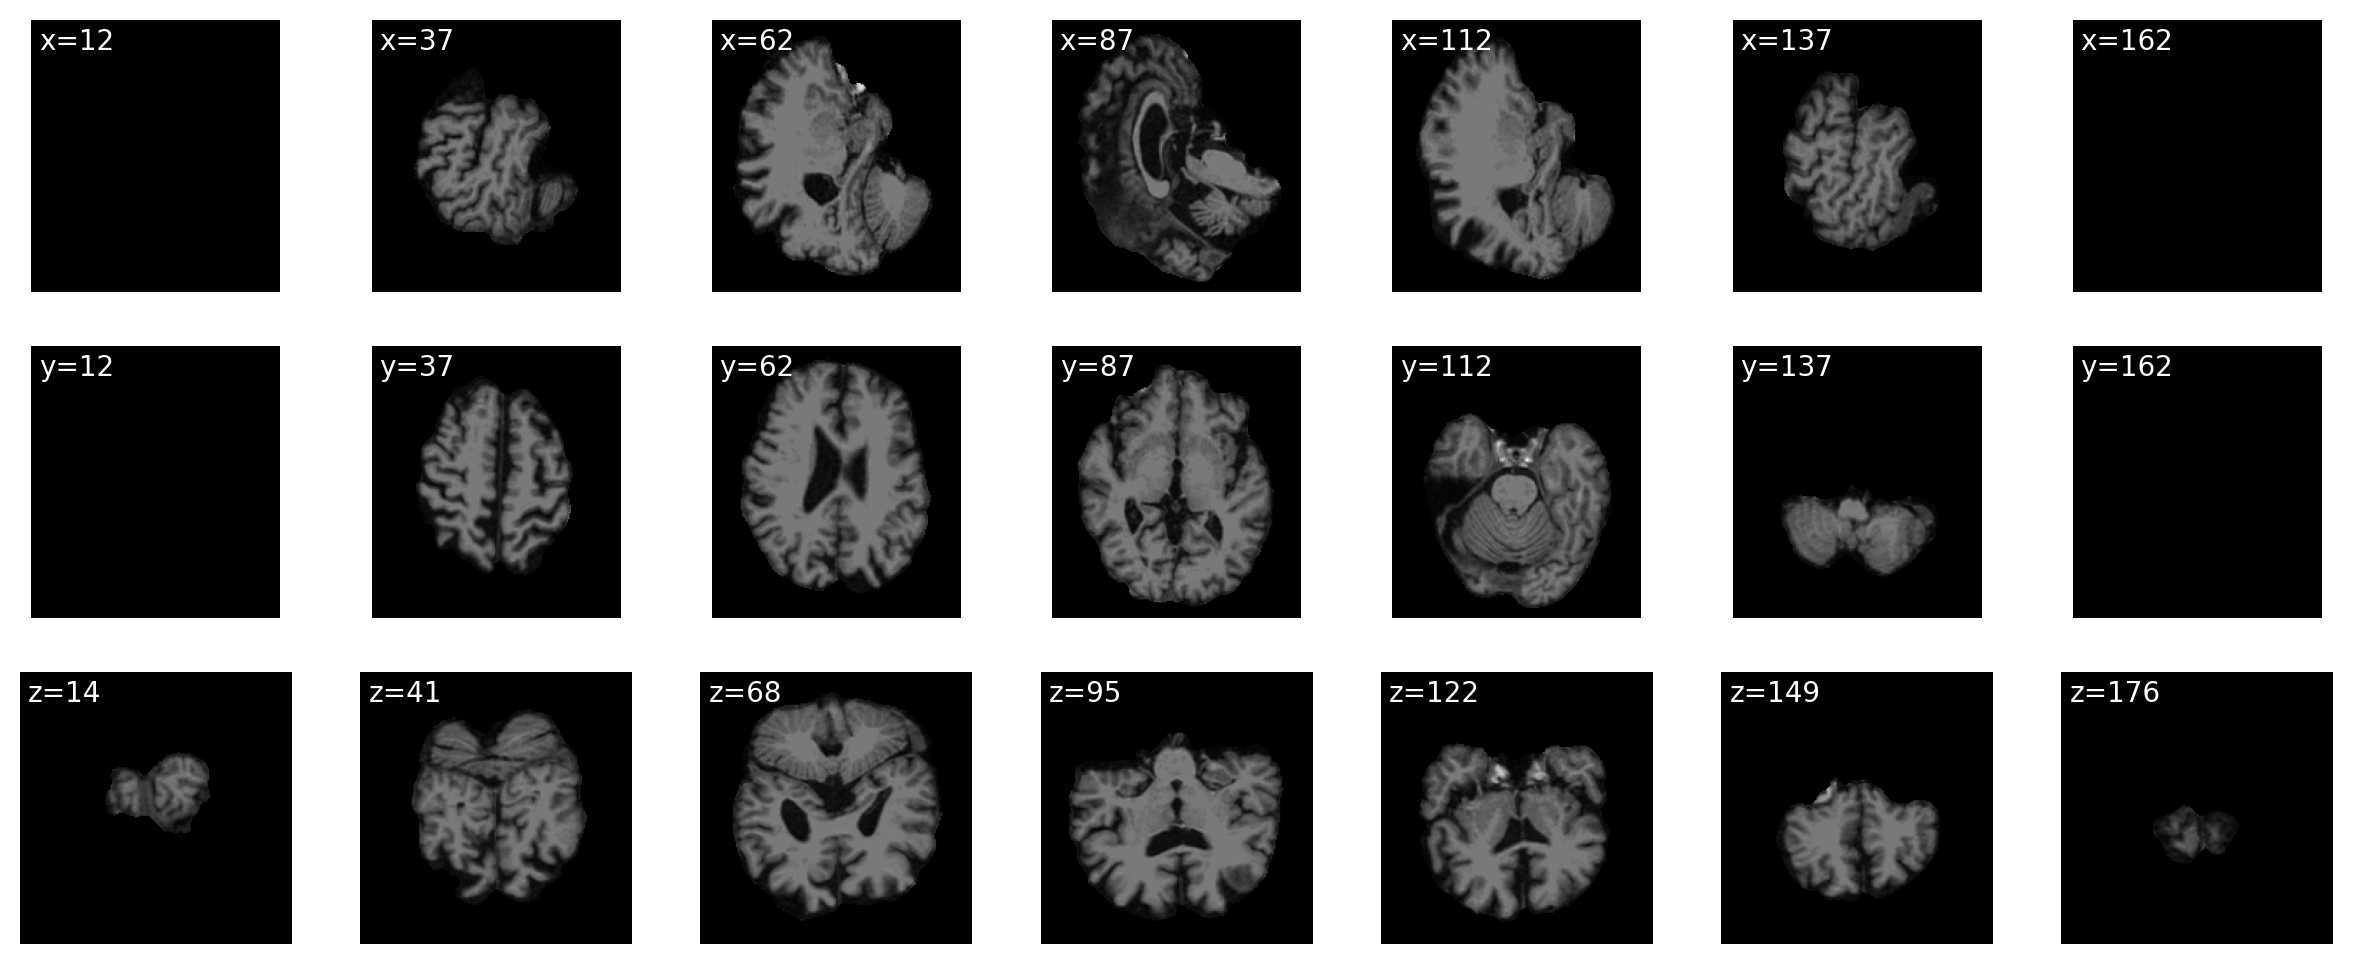

In [142]:
i = 6
print(train_dataset.get_raw_image(5).shape)
utils.plot_slices(train_dataset.get_raw_image(4))

tensor(0.) tensor(231.) None None


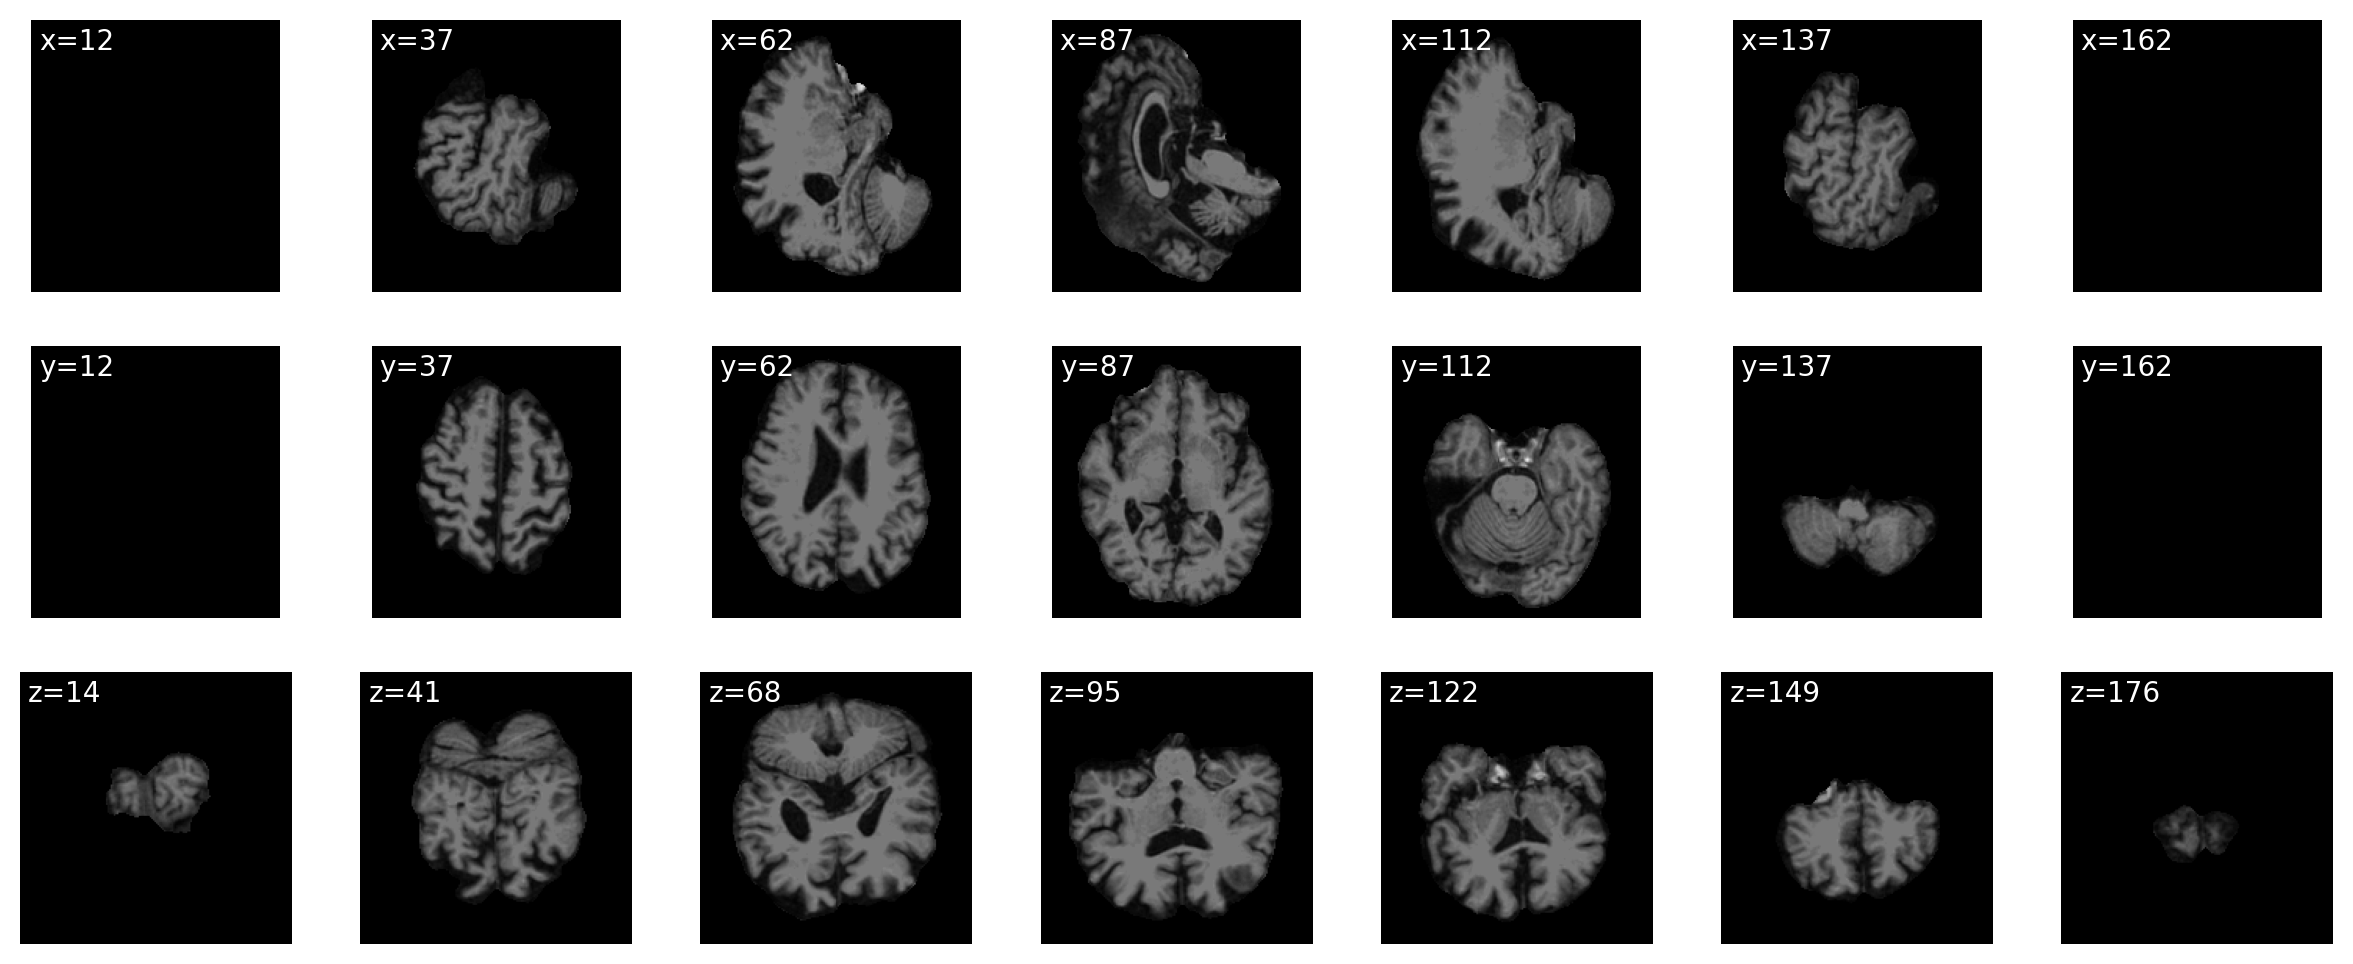

In [144]:
utils.plot_slices(train_dataset[4][0][0])

tensor(0.) tensor(204.) None None


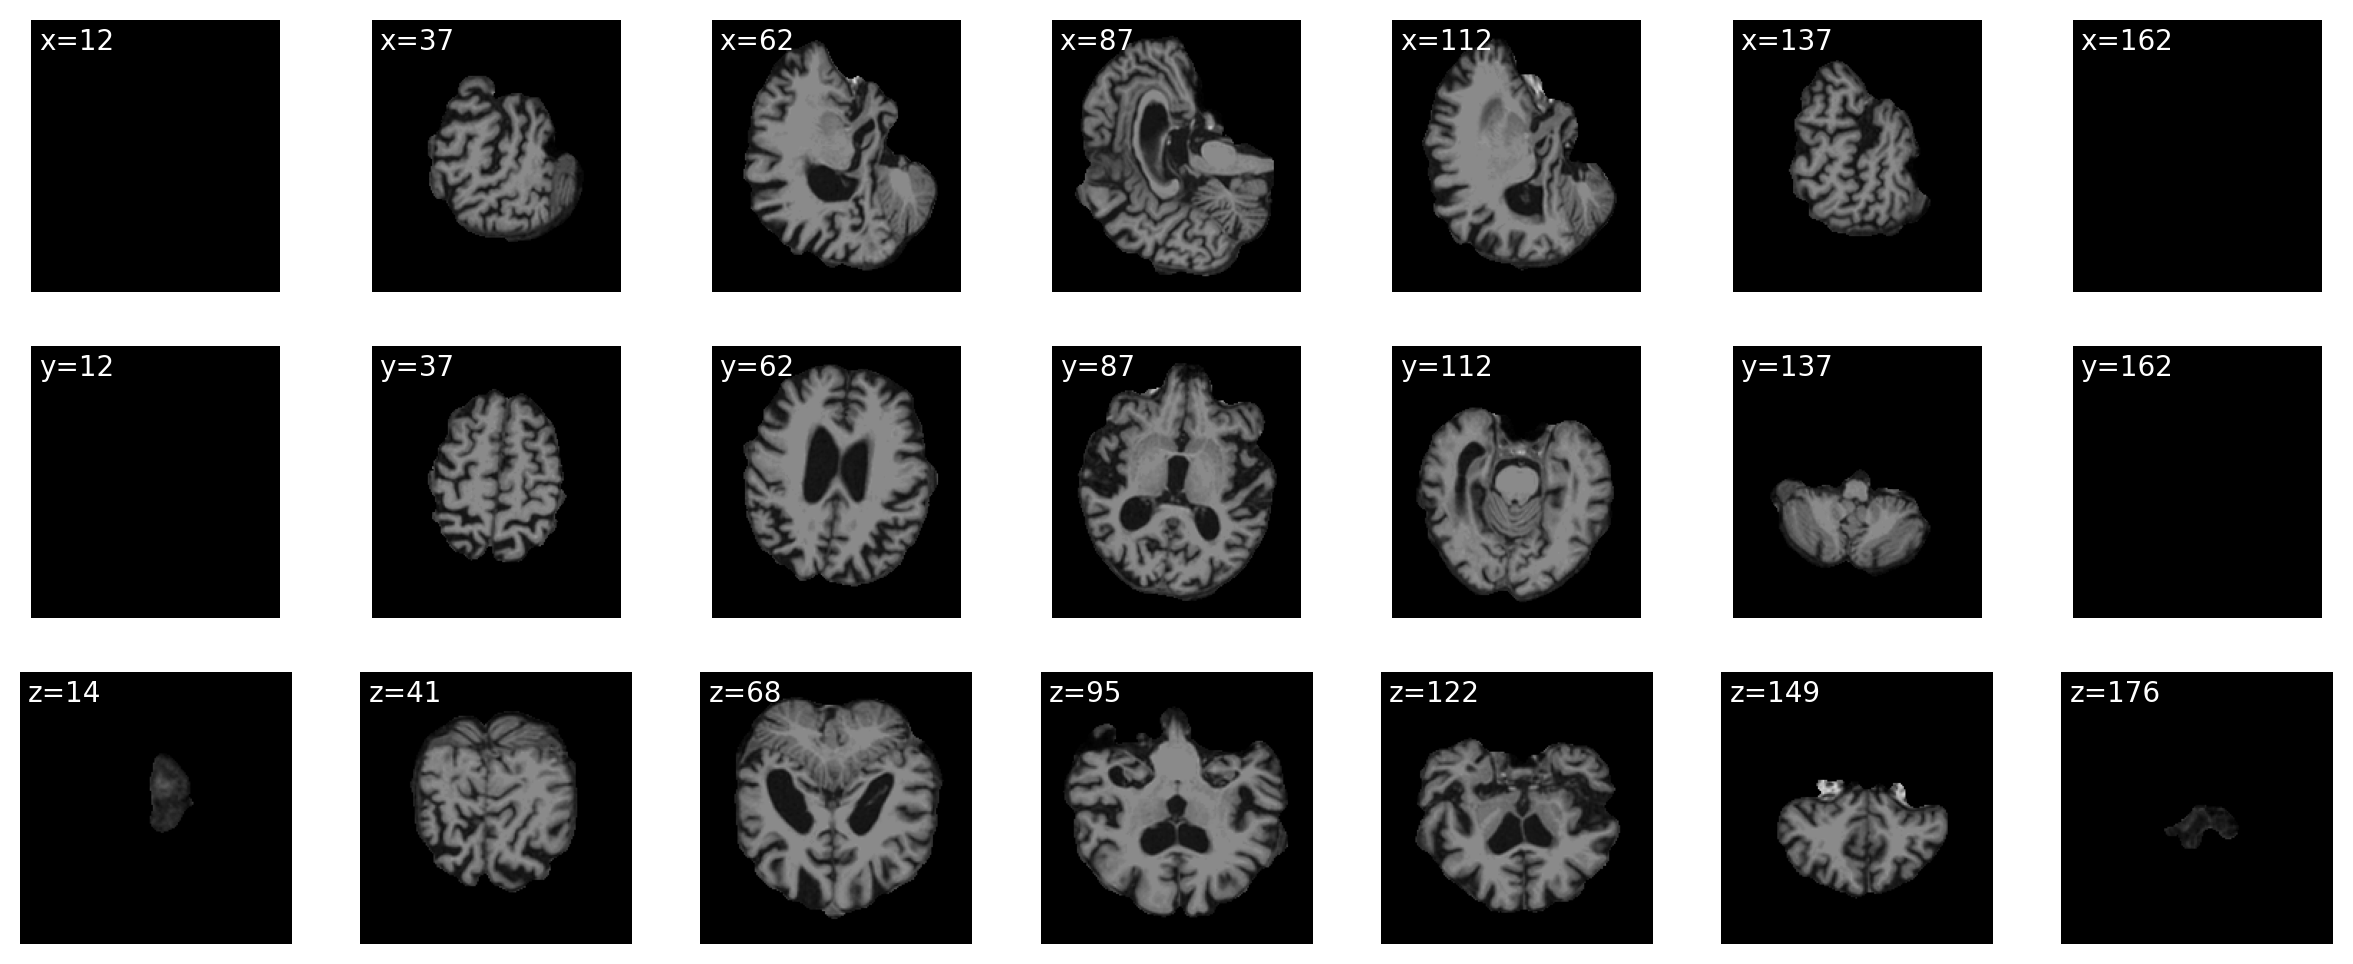

In [75]:
utils.plot_slices(train_dataset[2][0][0])

In [79]:
# print(train_dataset[4][0][0])
# print(train_dataset.labels)
# print(train_dataset.labels[3])

In [146]:
net, trainer, cuda_device = models.build_model()

GPU not available


In [150]:
print(net)

ClassificationModel3D(
  (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_1_bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv_2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_2_bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv_3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_3_bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv_4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4_bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_1): Linear(in_features=2304, out_features=128, bias=True)
  (dense_2): Linear(in_features=128, out_features=64, bias=True)
  (dense_3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
  (dropout2): Dropout(p=0, inplace=False)
)


In [152]:
train_loader, val_loader = datasets.build_loaders(train_dataset, val_dataset)

In [154]:
models.train_model(trainer, train_loader, val_loader, cuda_device, num_epoch=20)

Epoch 1/20:   0%|          | 1/200 [00:25<1:24:50, 25.58s/ batches]/Users/tamal/Documents/GitHub/cnn-interpretability/models.py:300: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return super(CategoricalAccuracyWithLogits, self).__call__(F.softmax(y_pred), y_true)
Epoch 1/20: 100%|██████████| 200/200 [27:18<00:00,  6.70s/ batches, acc_metric=52.6306, loss=0.7057]/opt/anaconda3/lib/python3.12/site-packages/torchsample/modules/module_trainer.py:659: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(input_batch, volatile=volatile), Variable(target_batch, volatile=volatile, requires_grad=False)
Epoch 1/20: : 201 batches [28:32,  8.52s/ batches, val_loss=0.6690, val_acc_metric=51.3333, acc_metric=52.6306, loss=0.7057]                 
Epoch 2/20: : 201 batches [22:31,  6.72s/ batches, val_loss=0.6563, val_acc_metric=58.6667, acc_metric=52.9274, loss=0.69

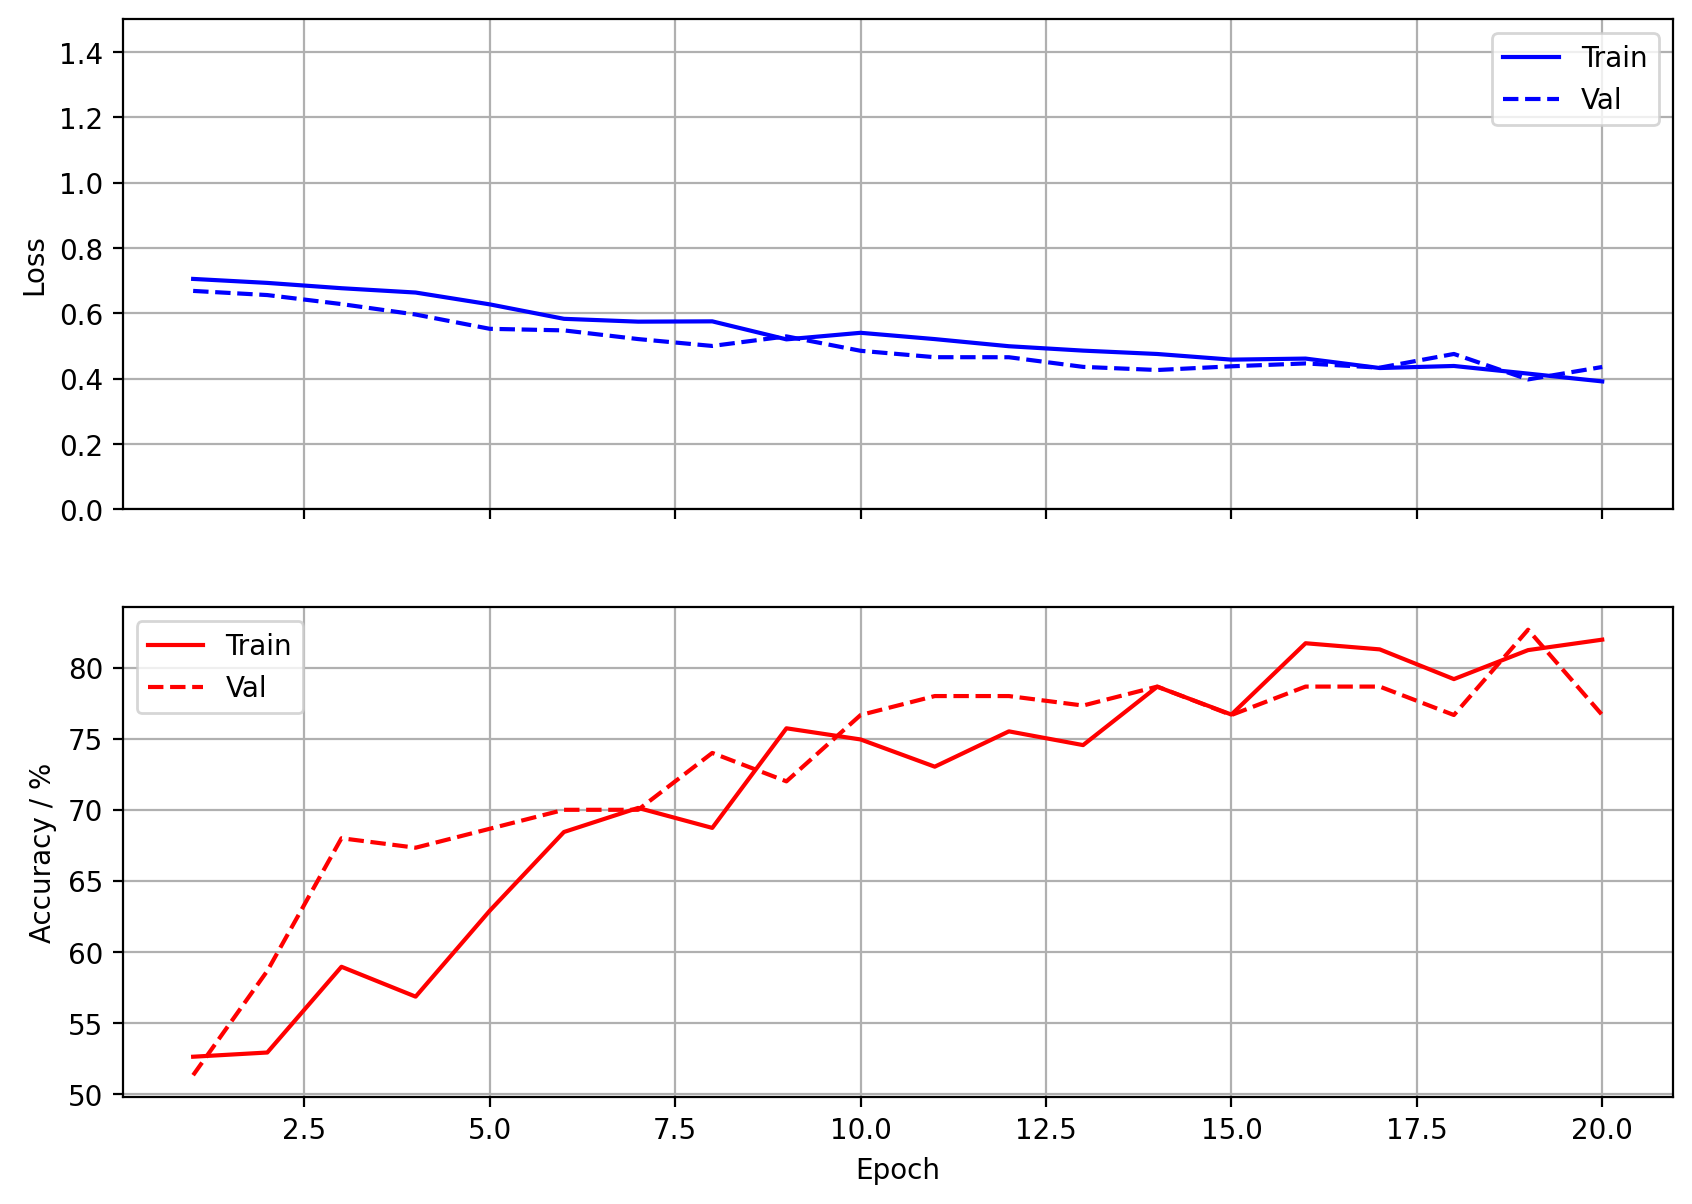

In [179]:
utils.plot_learning_curve(trainer.history)

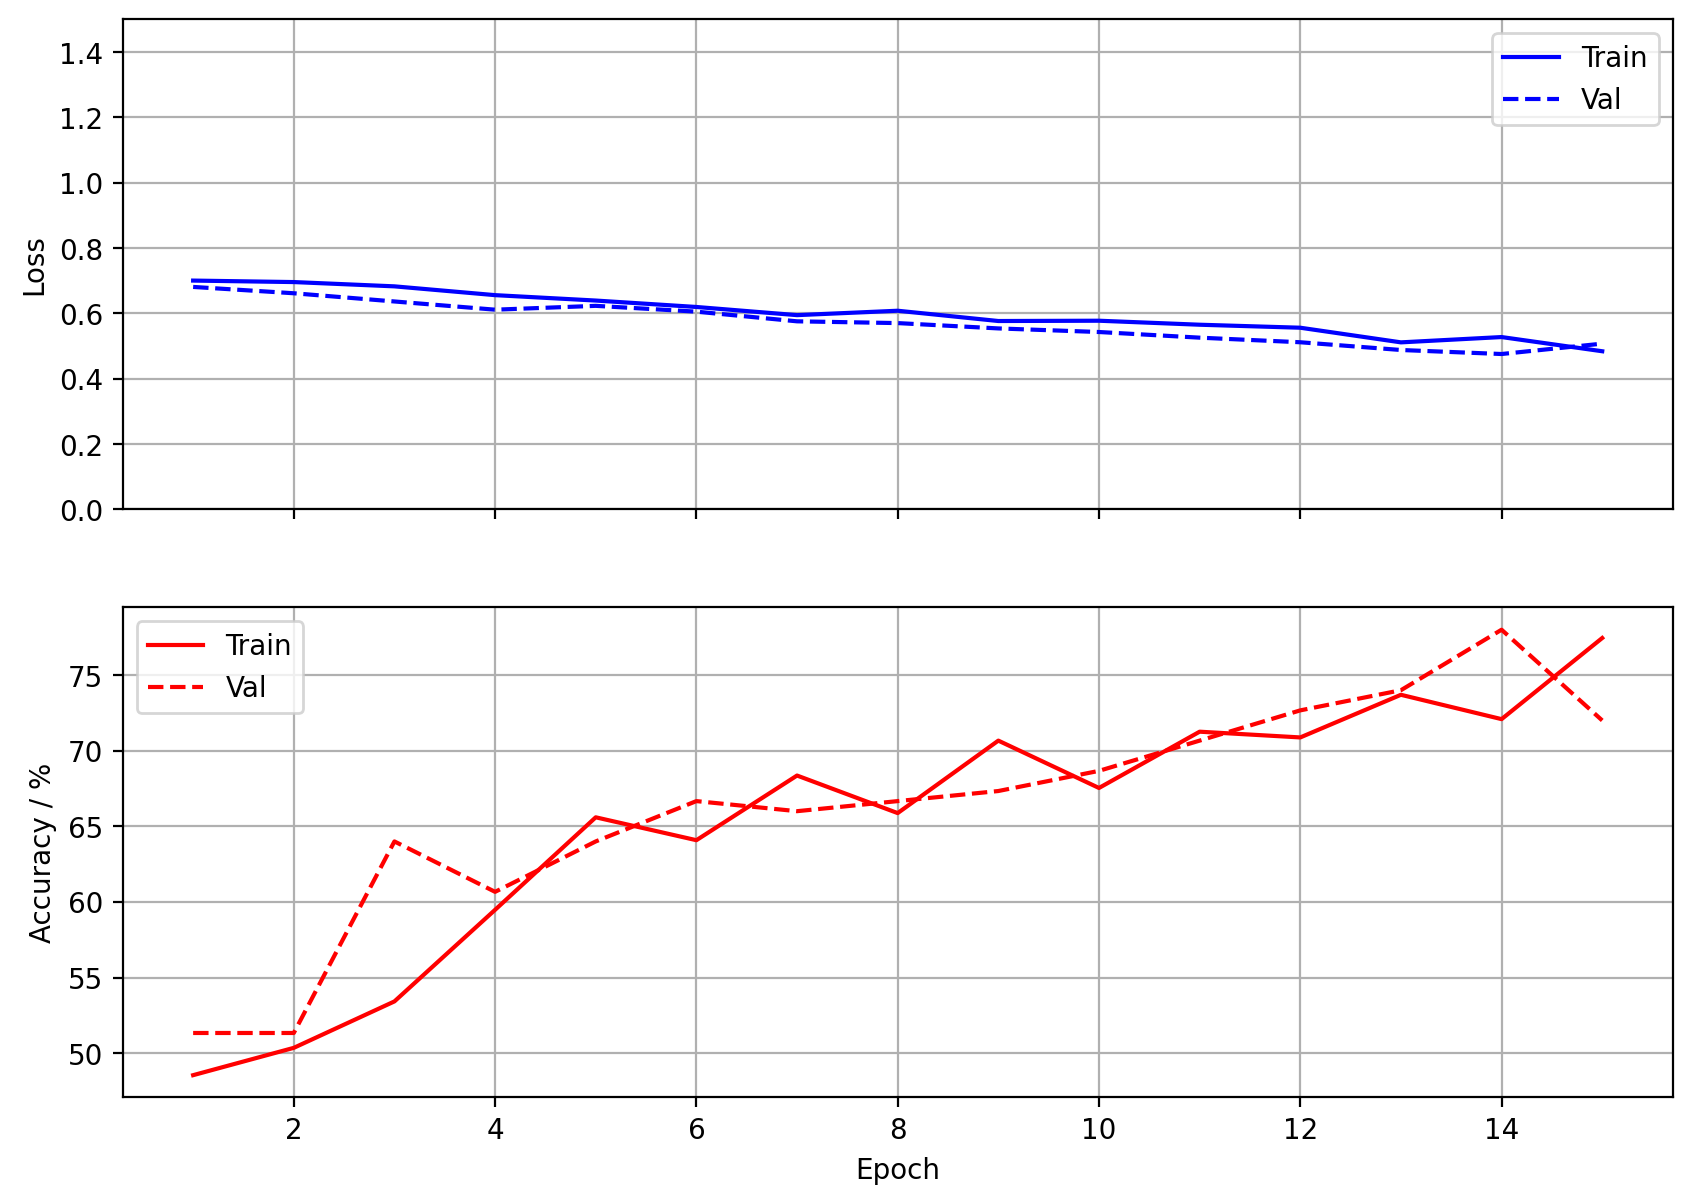

In [91]:
utils.plot_learning_curve(trainer.history)

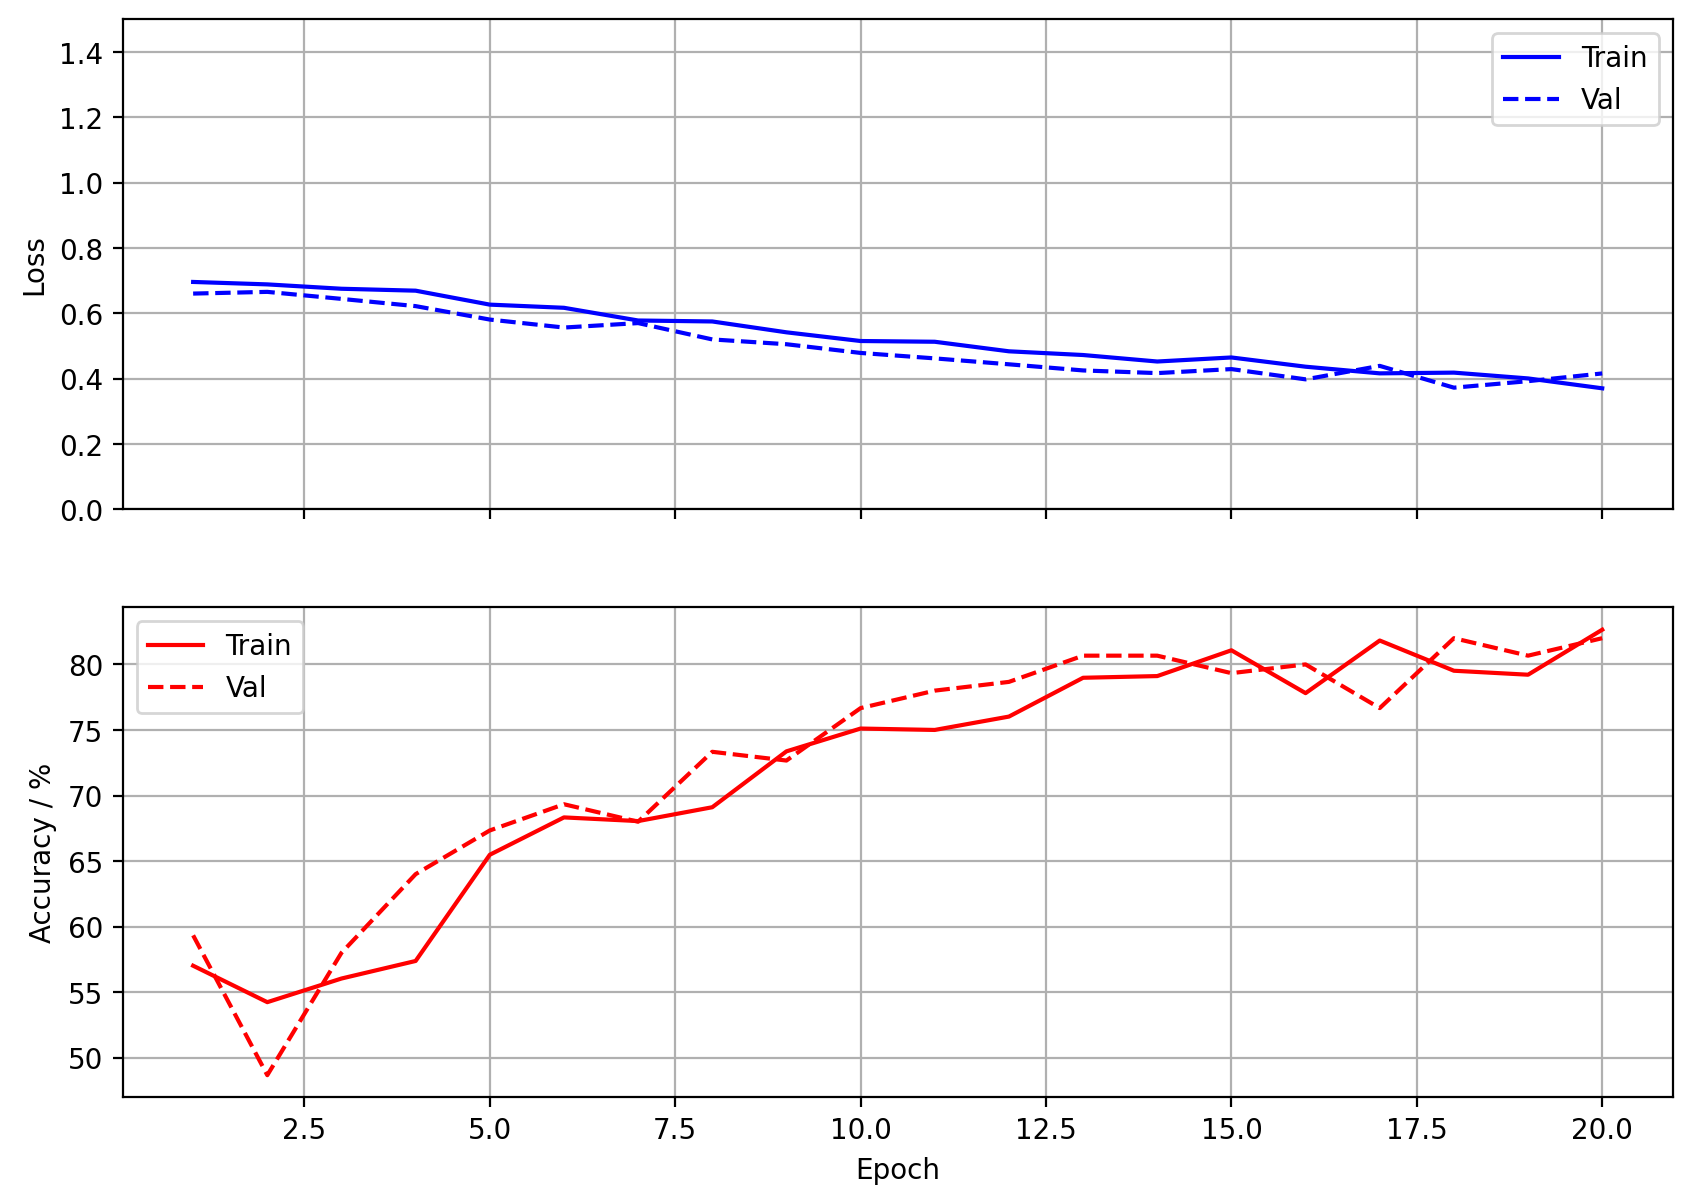

In [45]:
utils.plot_learning_curve(trainer.history)

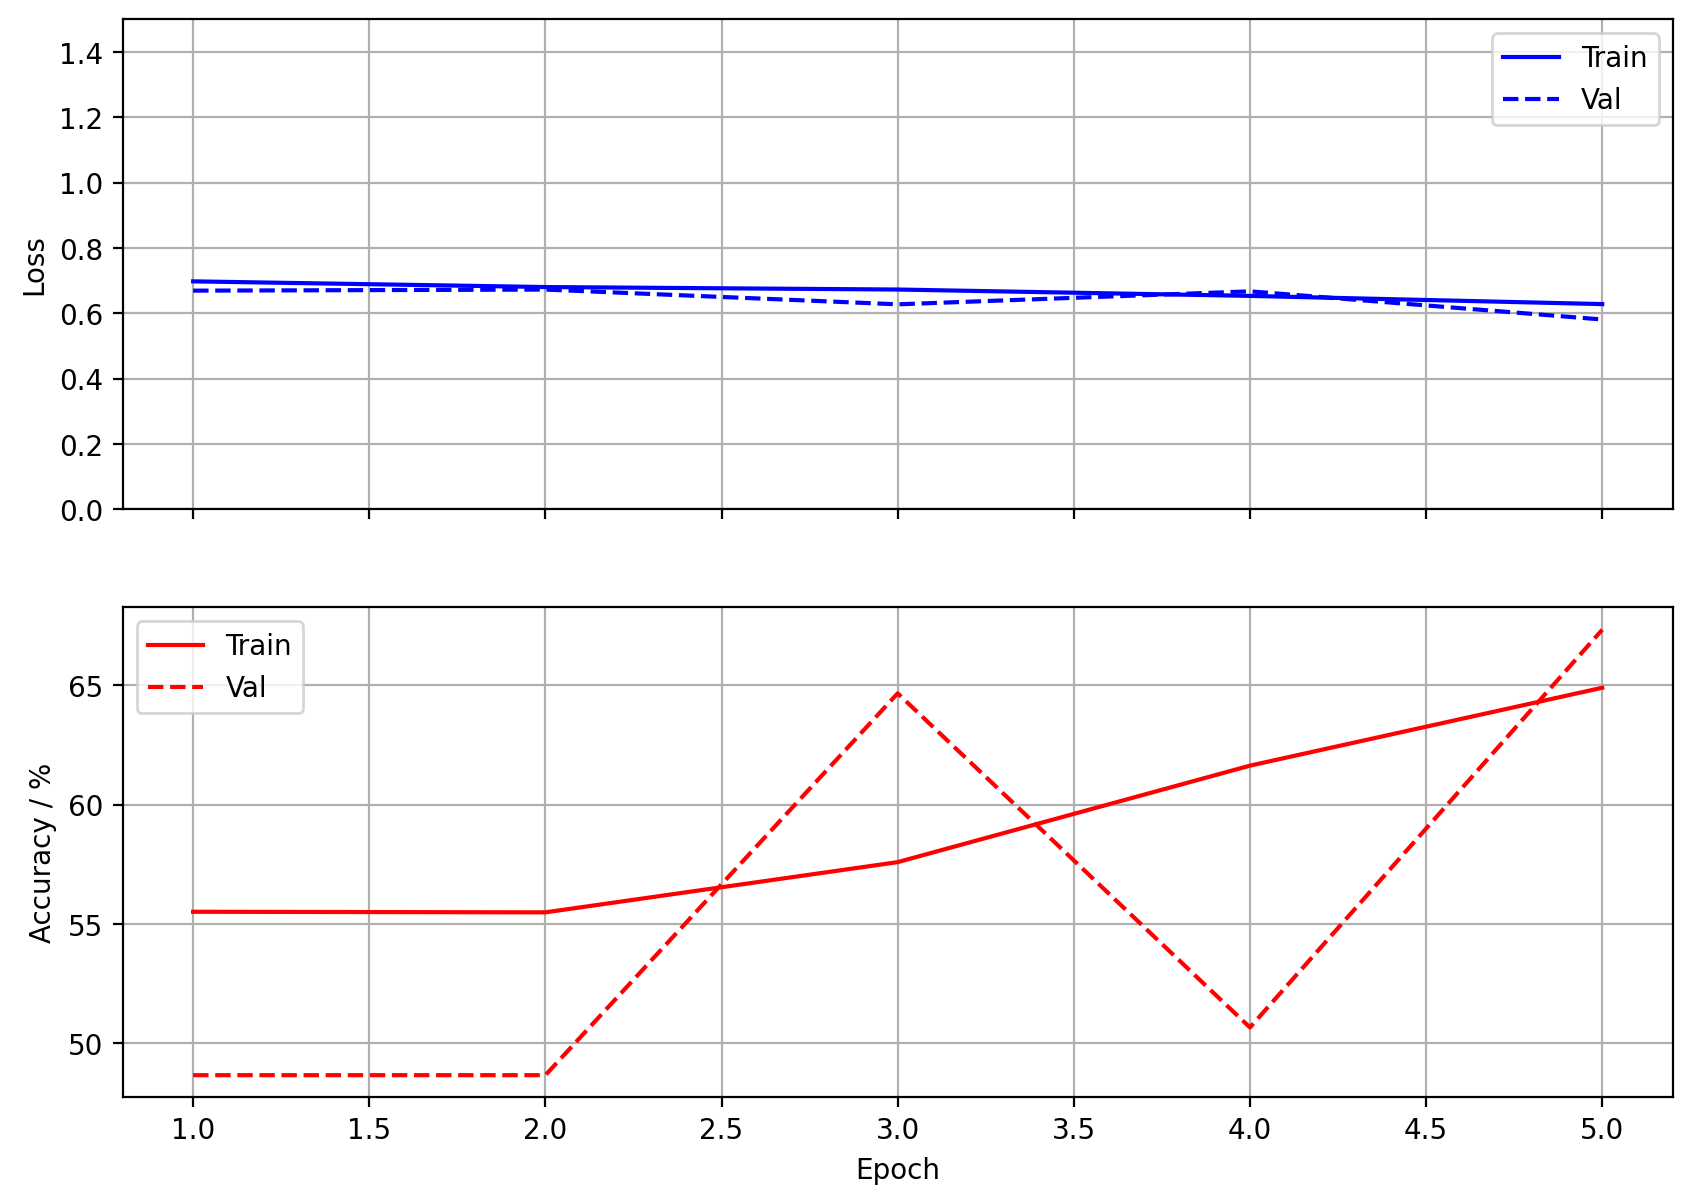

In [38]:
utils.plot_learning_curve(trainer.history)

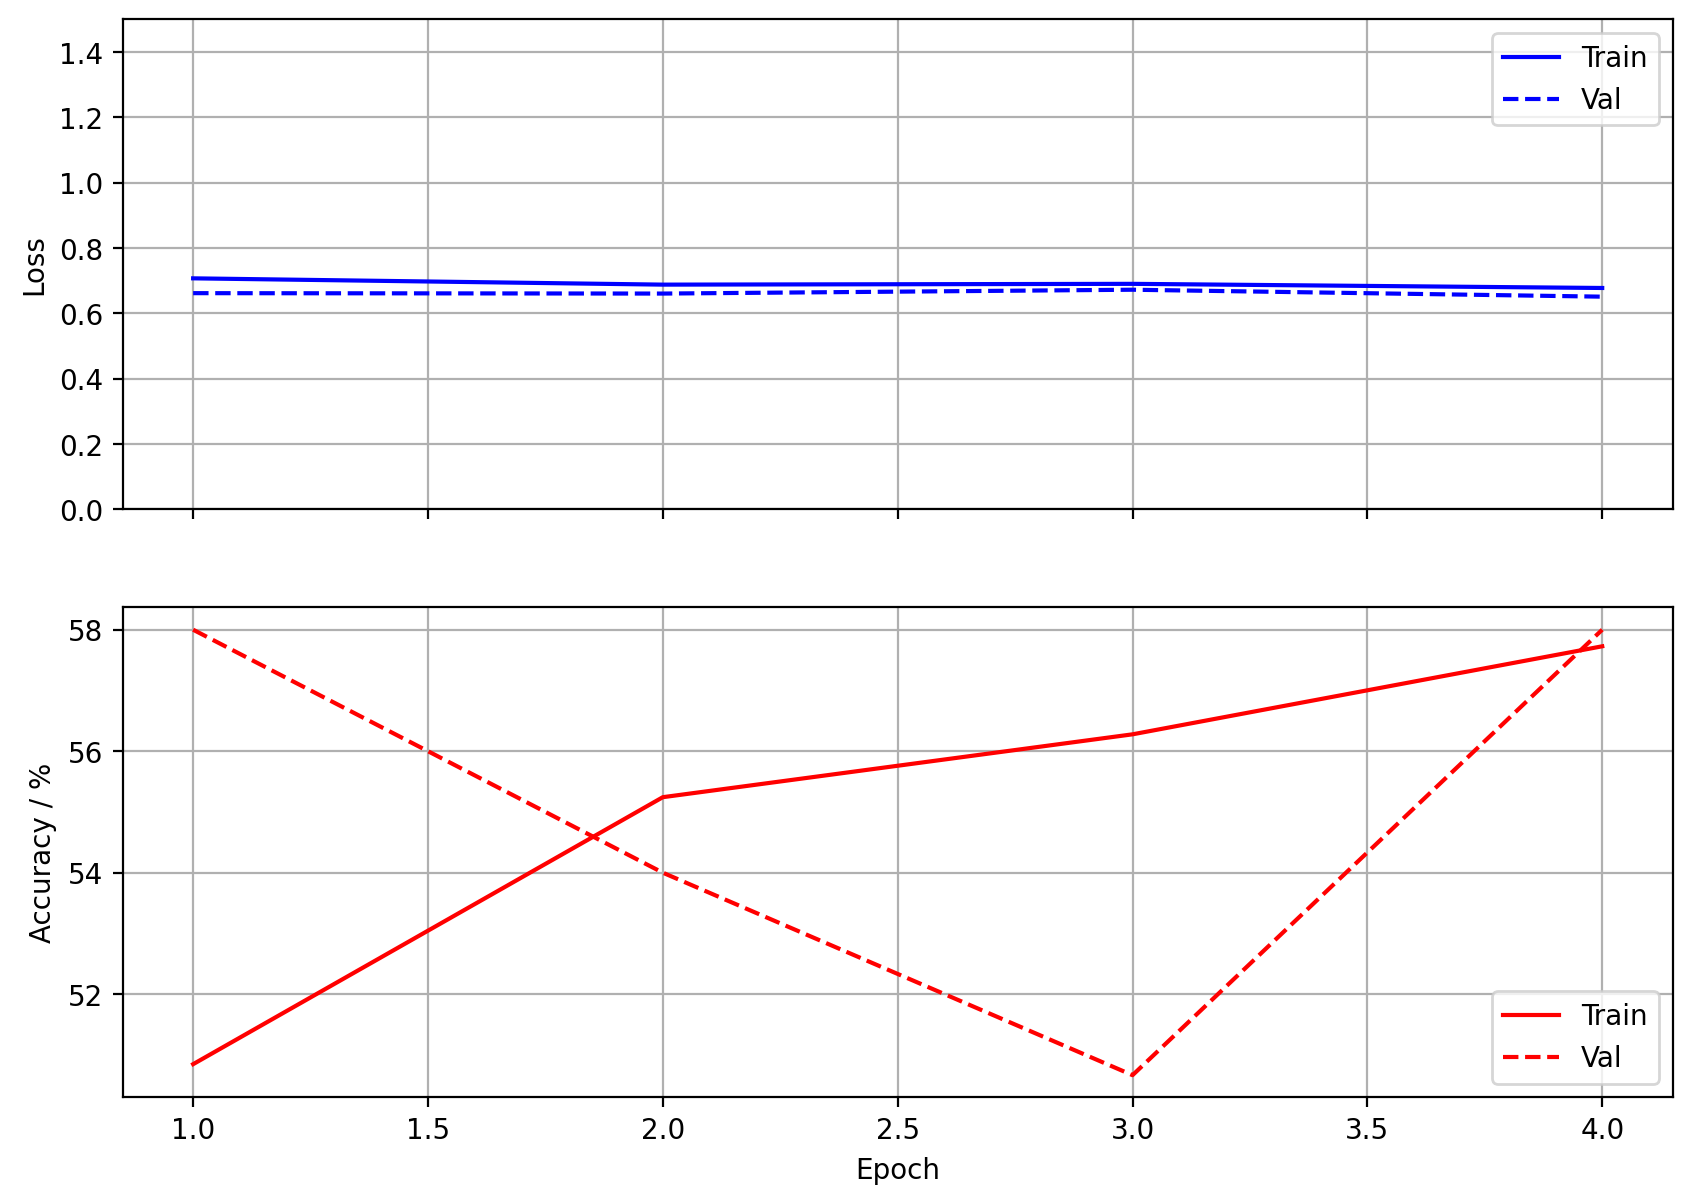

In [43]:
utils.plot_learning_curve(trainer.history)

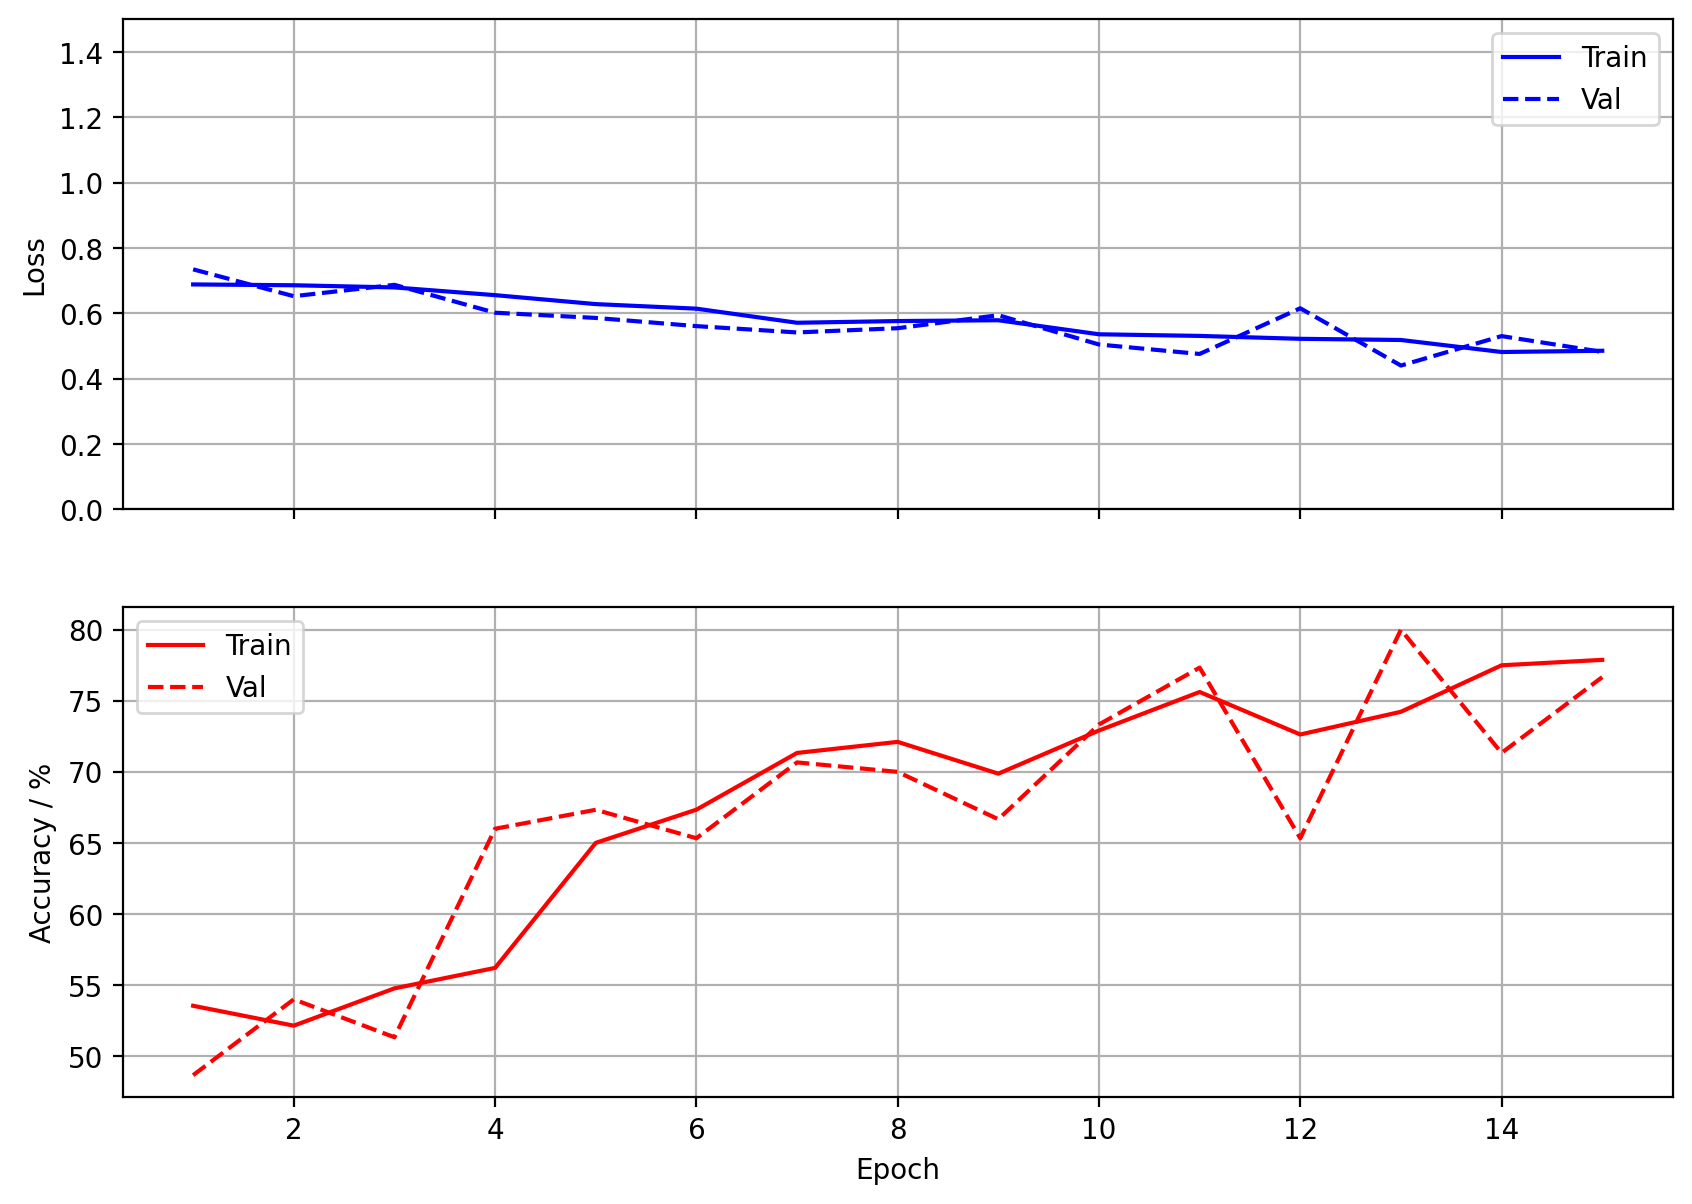

In [37]:
utils.plot_learning_curve(trainer.history)

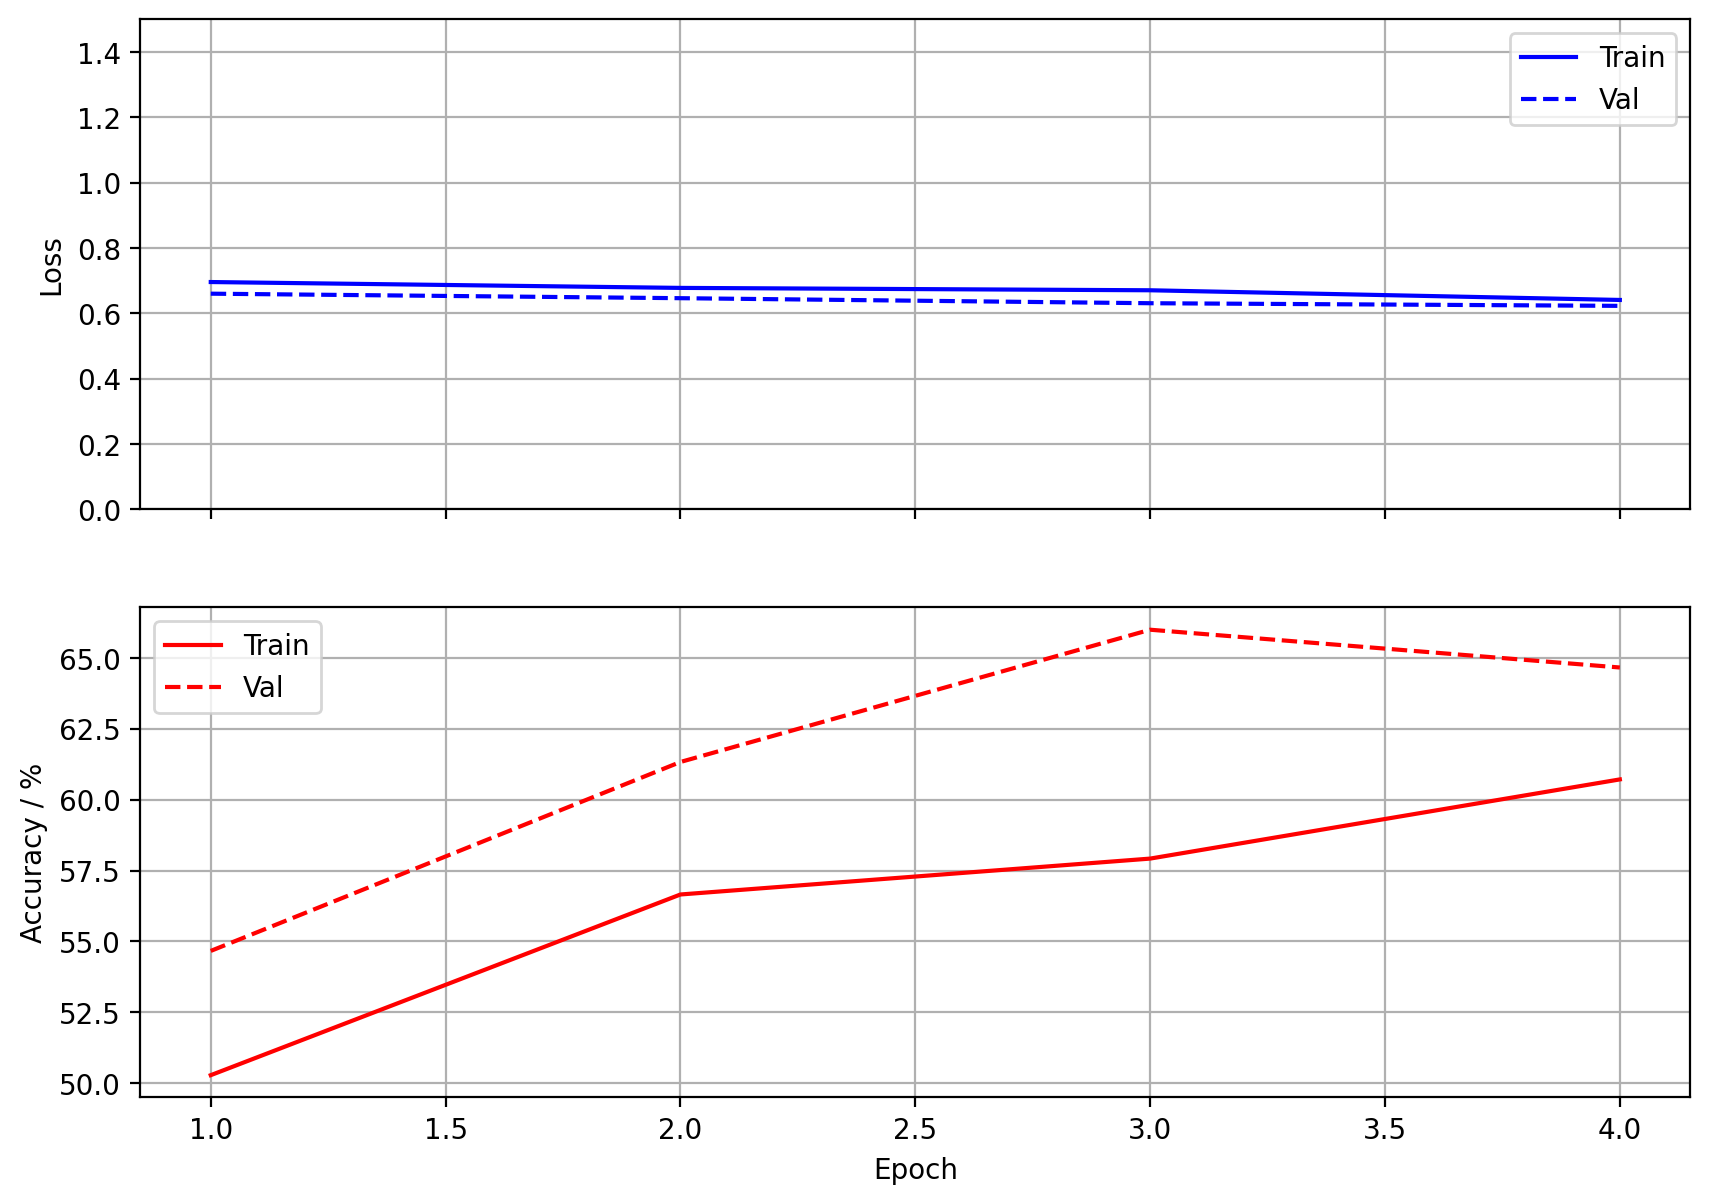

In [47]:
utils.plot_learning_curve(trainer.history)

In [181]:
torch.save(net, 'softmax-output_batch_normalization_e20.pt')
torch.save(net.state_dict(), 'softmax-output_state-dict-batch_normalization_e20.pt')

In [183]:
import datasets, models, interpretation

In [49]:
models.calculate_roc_auc(trainer, val_loader, cuda_device)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1087, in get_code
  File "<frozen importlib._bootstrap_external>", line 1187, in get_data
KeyboardInterrupt


KeyboardInterrupt: 

In [185]:
model = models.ClassificationModel3D()
model.load_state_dict(torch.load('softmax-output_state-dict-batch_normalization_e20.pt'))

<All keys matched successfully>

In [4]:
print(model)

NameError: name 'model' is not defined

In [187]:
if torch.cuda.is_available():
    net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

GPU not available


In [189]:
train_dataset, test_dataset = datasets.build_datasets(train_filenames, train_labels, test_filenames, test_labels,  False)

Dataset is not normalized, this could dramatically decrease performance


In [191]:
train_loader, test_loader = datasets.build_loaders(train_dataset, test_dataset)

In [193]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [195]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [197]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 81.33%
Test Precision: 0.85, Test Recall: 0.81, Test F1-Score: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80        81
           1       0.72      0.97      0.83        69

    accuracy                           0.81       150
   macro avg       0.84      0.83      0.81       150
weighted avg       0.85      0.81      0.81       150



In [109]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 74.00%
Test Precision: 0.78, Test Recall: 0.74, Test F1-Score: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        81
           1       0.89      0.49      0.64        69

    accuracy                           0.74       150
   macro avg       0.79      0.72      0.72       150
weighted avg       0.78      0.74      0.72       150



In [63]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 80.00%
Test Precision: 0.85, Test Recall: 0.80, Test F1-Score: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84        81
           1       0.98      0.58      0.73        69

    accuracy                           0.80       150
   macro avg       0.85      0.78      0.78       150
weighted avg       0.85      0.80      0.79       150



In [66]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 76.67%
Test Precision: 0.78, Test Recall: 0.77, Test F1-Score: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        81
           1       0.70      0.86      0.77        69

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.78      0.77      0.77       150



In [57]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 78.00%
Test Precision: 0.82, Test Recall: 0.78, Test F1-Score: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83        81
           1       0.95      0.55      0.70        69

    accuracy                           0.78       150
   macro avg       0.83      0.76      0.76       150
weighted avg       0.82      0.78      0.77       150



In [65]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 69.33%
Test Precision: 0.75, Test Recall: 0.69, Test F1-Score: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77        81
           1       0.87      0.39      0.54        69

    accuracy                           0.69       150
   macro avg       0.76      0.67      0.66       150
weighted avg       0.75      0.69      0.66       150



In [ ]:
target_layer = model.conv3  # Last convolutional layer
gradcam = LayerGradCam(model, target_layer)

# Select a test sample
# sample, label = test_dataset[0]
sample = mci_image

# Compute Grad-CAM
attributions = gradcam.attribute(sample, target=int(mci_label))
attributions = attributions.squeeze().cpu().detach().numpy()

# Visualize middle slice
plt.imshow(attributions[attributions.shape[0] // 2, :, :], cmap='jet')
plt.title("LAYER CAM Visualization (Middle Slice)")
plt.colorbar()
plt.show()

In [64]:
# model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 56.67%
Test Precision: 0.63, Test Recall: 0.57, Test F1-Score: 0.48
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.14      0.24        71
           1       0.55      0.95      0.70        79

    accuracy                           0.57       150
   macro avg       0.63      0.55      0.47       150
weighted avg       0.63      0.57      0.48       150



In [39]:
model1 = models.ClassificationModel3D()
model1.load_state_dict(torch.load('softmax-output_state-dict1.pt'))

<All keys matched successfully>

In [41]:
if torch.cuda.is_available():
    model1.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

GPU not available


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
# model.load_state_dict(torch.load(best_model_path))
model1.eval()  # Set model to evaluation mode for testing

# Testing Loop
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model1(inputs)  # Forward pass
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class

        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate F1-Score and Classification Report for Test Data
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1-Score: {f1:.2f}")

# Classification Report (Precision, Recall, F1-score for each class)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 63.12%
Test Precision: 0.55, Test Recall: 0.63, Test F1-Score: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       102
           1       0.40      0.03      0.06        58

    accuracy                           0.63       160
   macro avg       0.52      0.50      0.42       160
weighted avg       0.55      0.63      0.51       160



In [79]:
model2 = models.ClassificationModel3D()
model2.load_state_dict(torch.load('softmax-output_state-dict_pre_trained.pt'))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.